# Ablation Analysis: Training Dataset Size and Noise Characteristics

In this notebook, we test how the composition of the training dataset affects the performance of the LSTM model. Specifically, we compare three versions of the model:

1. **Full dataset model** – trained on all 120,000 synthetic samples (40,000 per pulse archetype).  
2. **Reduced dataset model** – trained on a smaller set of 6,000 samples (2,000 per pulse archetype), with all noise and artifacts included. 
3. **Reduced dataset w/o colored noise** – trained on the same 6,000-sample subset, but with colored noise removed.

We evaluate these models using a synthetic test signal with known ground truth, following the same procedure as in the baseline comparisons (`benchmark_LSTM_with_DWT_and_TDDR.ipynb`):
1. **Process the same input** with each LSTM models.  
2. **Detect systolic peaks** → compute IBI → derive HR.  
3. **Detect valleys** → segment pulses → compute averaged waveforms.  

## Metrics
- **HR accuracy:** Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE).  
- **Waveform similarity:** Pearson correlation (r) and absolute time-to-peak difference (Δ|TPP|).  
- **Event detection precision:** Precision = TP + (TP + FP), with a tolerance of **±60 ms** (≈ 3 samples at 50 Hz) for matching detected peaks/valleys to ground truth.

For questions, please contact Jingyi Wu (jingyiwu@andrew.cmu.edu).


## Import packages

In [1]:
# Uncomment the next line to install your repo dependencies.
# !pip install -r requirements_test.txt

In [2]:
import os
import math
import random

import numpy as np
import h5py
from scipy.io import loadmat

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.gridspec as gridspec
import plotly.io as pio
pio.renderers.default = 'iframe' # this might create a folder named "iframe_figures" and save the interactive plots generated by this script

from utils import * # custom helper functions
color5 = ['#eb5055', '#405FC1', '#ffaa1c', '#62a140', '#9E3AB7'] # Color for plots

## 1. Load pre-trained LSTM model

In [3]:
# Select device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# Candidate model files
model_names = [
    'lstm_full_dataset.pt', # full dataset
    'lstm_reduced_dataset.pt', # reduced dataset
    'lstm_reduced_no_colored_noise.pt' # reduced dataset, no colored noise
]

model_folder = "models/"

# Pick model by index
model_name1 = model_names[0]
model_name2 = model_names[1]
model_name3 = model_names[2]

# Load model 1
model1 = LSTMDetectionModel(n_hid=256, n_layers=1).to(device) # Initialize model architecture
state_dict1 = torch.load(os.path.join(model_folder, model_name1), map_location=device) # Load saved weights
model1.load_state_dict(state_dict1)
model1 = model1.to(device) # Move model to device (redundant but explicit)
# model1.eval()
print("Model 1 loaded successfully!")

# Load model 2
model2 = LSTMDetectionModel(n_hid=256, n_layers=1).to(device) # Initialize model architecture
state_dict2 = torch.load(os.path.join(model_folder, model_name2), map_location=device) # Load saved weights
model2.load_state_dict(state_dict2)
model2 = model2.to(device) # Move model to device (redundant but explicit)
# model2.eval()
print("Model 2 loaded successfully!")

# Load model 3
model3 = LSTMDetectionModel(n_hid=256, n_layers=1).to(device) # Initialize model architecture
state_dict3 = torch.load(os.path.join(model_folder, model_name3), map_location=device) # Load saved weights
model3.load_state_dict(state_dict3)
model3 = model3.to(device) # Move model to device (redundant but explicit)
# model3.eval()
print("Model 3 loaded successfully!")

Device: cpu
Model 1 loaded successfully!
Model 2 loaded successfully!
Model 3 loaded successfully!


/var/folders/x8/2tyh0lwd3v73c3yx2py26lwm0000gn/T/ipykernel_99824/1121108783.py:21: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

/var/folders/x8/2tyh0lwd3v73c3yx2py26lwm0000

## 2. Load test data and preprocessing

In this section, we load example synthetic noisy signals with ground truth. Users can toggle between them by adjusting the index below.


In [4]:
# Pick dataset
test_file = 'synthetic_dataset1.mat' # (1/f)^1 noise with amplitude 0.2
print("Test file: " + test_file + " is picked!")

# Build full path and load dataset
test_folder = 'synthetic_data/'
test_path = test_folder + test_file
dataset = loadmat(test_path)
print(dataset.keys())

Test file: synthetic_dataset1.mat is picked!
dict_keys(['__header__', '__version__', '__globals__', 'alpha', 'amplitude', 'note', 'signal_test', 'time'])


In [5]:
# For paper analyses and figures, we used idx_signal = 0, for other signals, user might need to manually tune some parameters
idx_signal = 0

# Preproceesed noisy signal
data_pick = dataset['signal_test'][idx_signal,:,0].reshape(-1, 1).T
print(data_pick.shape)  # should be 1 × time

# Ground truth signal
data_clean = dataset['signal_test'][idx_signal,:,1].reshape(-1, 1).T
print(data_clean.shape)  # should be 1 × time

# sampling frequency
# Note: if it differs from 50 Hz (training data fs), it will be resampled later
fs_data = 50.0
print(fs_data)

# Figure title based on filename for plotting
figure_title = f"{test_file.removesuffix('.mat')}"
print(figure_title)


(1, 3000)
(1, 3000)
50.0
synthetic_dataset1


### Preprocessing

Preprocessing steps:

1. Resample to 50 Hz (to match training data).
2. Center signal around zero.
3. Normalize so that pulsations roughly lie in [-1, 1].

Current implementation uses Hilbert transform and envelope detection to auto-scale the pulse amplitude, 
but it is not always perfect. Users may need to manually tune:

  `amplitude_scale` : controls vertical scaling
  
  `offset`          : shifts the center up or down

Practical tips:
   - After normalization, visually check the time trace for appropriate scaling.
   - An additional check is to look at segmented and averaged pulse waveforms 
     (plotted at the end of the script). If normalization is done correctly, both 
     raw and LSTM-processed averaged waveforms should have very similar amplitude and fall roughly within [-1, 1].
   - This step is critical: carefully adjusting scaling leads to much better results.

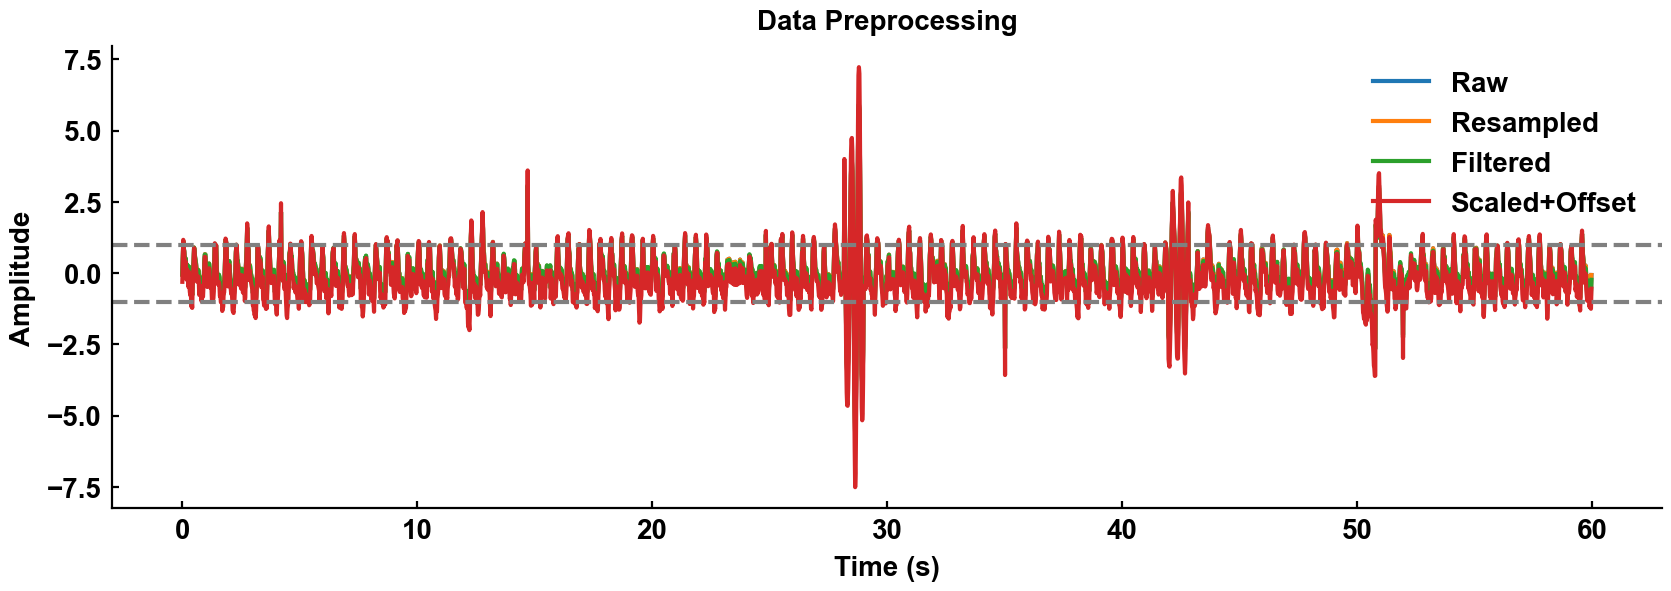

In [6]:
# Still need some preprocessing to center and normalize them
fs_origin = fs_data
fs_target = 50.0 # Training data were sampled at 50 Hz
time_trace_raw = data_pick

amplitude_scale = 1.2
offset = -0.25
t_nirs, time_trace, signal_scale = preprocess_signal(time_trace_raw, fs_origin, fs_target, amplitude_scale=amplitude_scale, offset=offset)

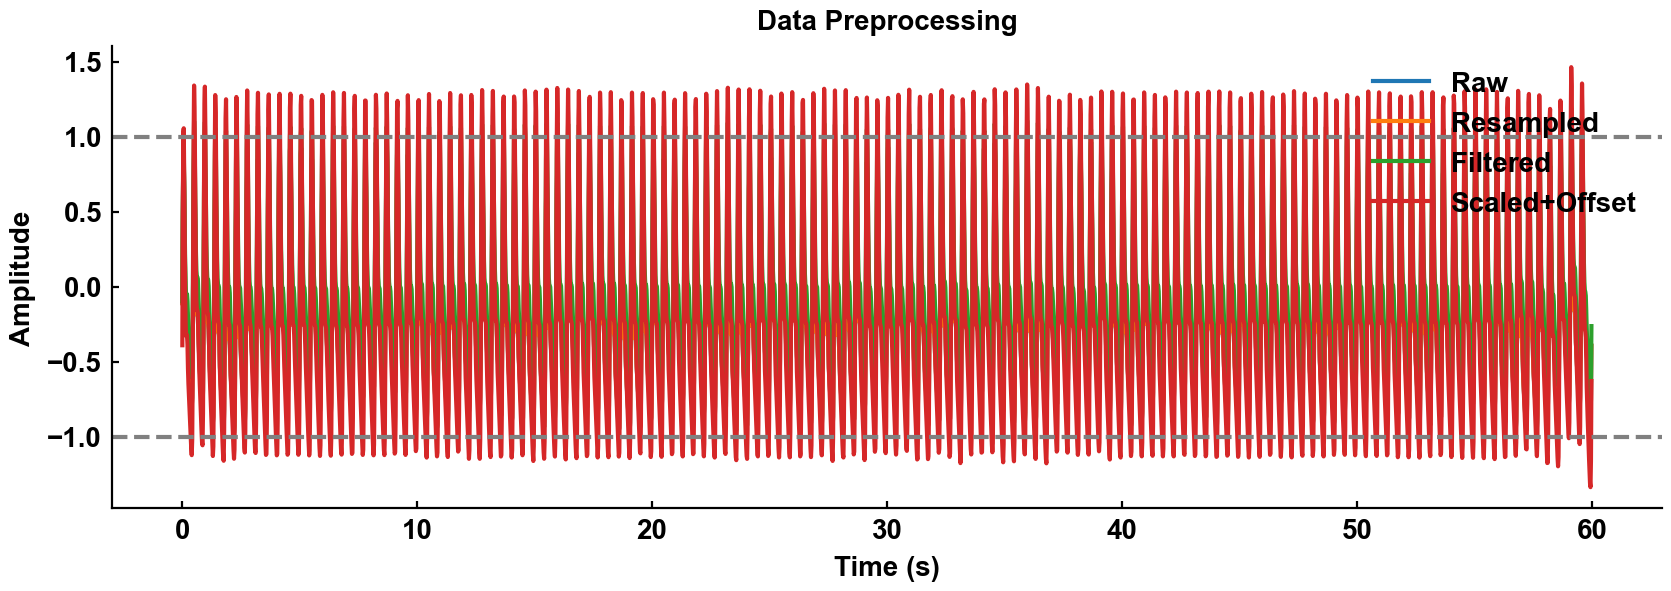

In [7]:
# Same for the ground truth pulsatile signal, for plotting purpose
_, data_clean_filt, _ = preprocess_signal(data_clean, fs_origin, fs_target, amplitude_scale=amplitude_scale, offset=offset)

## 3. Process signal with LSTM

For input signals of arbitrary length, we first segment them into fixed-length windows (the same size used during training).  
Each segment is processed independently by the trained LSTM model, and then recombined into a full-length time trace.  
Overlapping regions between segments are averaged for smooth reconstruction.

We also compare the raw vs. processed signals, estimate the signal quality index (SNR), and visualize spectrograms before and after processing.


In [8]:
# Segmentation parameters
# Window size must match training data length (1 min at 50 Hz → 3000 samples).
# Overlap size can be adjusted: larger overlap = smoother stitching, more compute.
window_size = 3000
overlap_size = 2000

# Segment the full trace into overlapping windows
segments = segment_time_trace(time_trace, window_size, overlap_size)

# Run the trained LSTM model on each segment, and then recombine processed segments into a single continuous trace
# Model 1
processed_segments1 = process_segments_with_lstm(model1, segments, device)
processed_time_trace1 = combine_processed_segments(processed_segments1, window_size, overlap_size, time_trace.shape[1])

# Model 2
processed_segments2 = process_segments_with_lstm(model2, segments, device)
processed_time_trace2 = combine_processed_segments(processed_segments2, window_size, overlap_size, time_trace.shape[1])

# Model 3
processed_segments3 = process_segments_with_lstm(model3, segments, device)
processed_time_trace3 = combine_processed_segments(processed_segments3, window_size, overlap_size, time_trace.shape[1])


**Compare original vs. processed signals**

**Note:**
- Interactive Plotly figure, it might take a long time to run, consider changing the plot setting/renderer or proceeding to later sections.
- Setting plot_segments=True will also show each individual segment.

In [9]:
# Model 1
plot_segments_comparison(time_trace, processed_time_trace1, segments, processed_segments1, window_size, overlap_size,
    title="Noisy and Processed Segments, Model 1: Full Dataset (120,000 samples)", plot_segments=False)

# Model 2
plot_segments_comparison(time_trace, processed_time_trace2, segments, processed_segments2, window_size, overlap_size,
    title="Noisy and Processed Segments, Model 2: Small Dataset (6,000 samples)", plot_segments=False)

# Model 3
plot_segments_comparison(time_trace, processed_time_trace3, segments, processed_segments3, window_size, overlap_size,
    title="Noisy and Processed Segments, Model 3: Small Dataset without Colored Noise (6,000 samples)", plot_segments=False)

### Identify and visualize low-SNR regions

In this subsection, we automatically detect low SNR regions (also see section 3) in the time trace and highlight them in the figure.  
This corresponds to the results figure in the paper, which provides both a global overview and detailed examples of artifact-induced distortions.

**Workflow:**
1. Use `extract_low_snr_regions()` to find regions where the SNR drops below a chosen threshold.  
2. Select the worst `n_regions` (based on minimum SNR), expand their time bounds slightly, and sort them chronologically.  
3. Plot the full time trace with shaded artifact regions (top panel), and zoom into selected regions (bottom row).  


In [10]:
# Step 1: automatically extract candidate low-SNR regions
# Returns start/end times for regions where SNR < threshold,
# sorted from worst (lowest SNR) to best.

# Indentifying from Model 1 results
low_snr_regions = extract_low_snr_regions(time_trace.squeeze(), processed_time_trace1.squeeze(), window_size=50, step_size=25, fs=50, threshold=None)
print("Low SNR Regions (start time, end time):", low_snr_regions,'\n')

# Step 2: expand each region by a small buffer (in seconds) for better visualization
buffer_time = 1 # seconds
regions_to_shade = []
for start_time, end_time in low_snr_regions:
    # Decrease the start time and increase the end time
    new_start_time = max(0, start_time - buffer_time)  # Ensure start time does not go below 0
    new_end_time = end_time + buffer_time
    regions_to_shade.append((new_start_time, new_end_time))

# Step 3: pick the worst few regions to plot (e.g., top 4)
n_regions = 4
if len(regions_to_shade) >= n_regions:
    regions_to_shade = regions_to_shade[0:n_regions]

# Sort the regions chronologically
regions_to_shade = sorted(regions_to_shade, key=lambda x: x[0])
print("Regions to shade (start time, end time):", regions_to_shade)

# For paper figures, we specified the regions manually:
# regions_to_shade = [(12.0, 18.0), (26.0, 32.0), (40.0, 46.0), (49.0, 53.0)]

# But for demonstration purpose, we will just use worst four regions indentified automatically.

Low SNR Regions (start time, end time): [(27.5, 29.5), (41.0, 44.5), (49.5, 53.0), (14.0, 15.5), (34.5, 36.0), (11.5, 13.0), (23.0, 25.5)] 

Regions to shade (start time, end time): [(13.0, 16.5), (26.5, 30.5), (40.0, 45.5), (48.5, 54.0)]


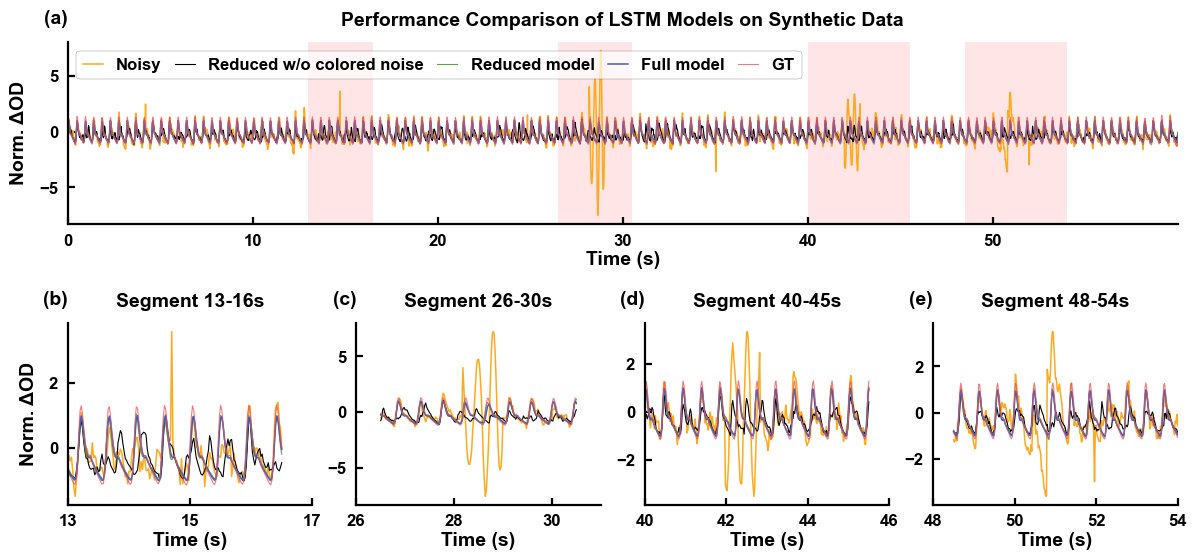

In [11]:
# Non-interactive version as shown in the paper
t = np.arange(0, processed_time_trace1.shape[1]) / fs_target

# Create a GridSpec with 2 rows and n columns:
#   Top row: full time trace
#   Bottom row: zoomed-in regions of low SNR
fig = plt.figure(figsize=(7.16, 3))
gs = gridspec.GridSpec(2, len(regions_to_shade), height_ratios=[1, 1])

# Full time trace on the entire top row (spanning all columns)
ax_full_trace = fig.add_subplot(gs[0, :])
ax_full_trace.plot(t, time_trace.squeeze(), label='Noisy', color=color5[2], linewidth=0.55)
ax_full_trace.plot(t, processed_time_trace3.squeeze(), label='Reduced w/o colored noise', color='k', linewidth=0.4)
ax_full_trace.plot(t, processed_time_trace2.squeeze(), label='Reduced model', color=color5[3], linewidth=0.4)
ax_full_trace.plot(t, processed_time_trace1.squeeze(), label='Full model', color=color5[1], linewidth=0.55)
ax_full_trace.plot(t, data_clean_filt.squeeze(), label='GT', color=color5[0], linewidth=0.4,alpha=0.75)

# Shade artifact regions
for start, end in regions_to_shade:
    ax_full_trace.axvspan(start, end, facecolor='red', edgecolor='none', alpha=0.1, label="")

ax_full_trace.set_title('Performance Comparison of LSTM Models on Synthetic Data', fontsize=7)
ax_full_trace.set_xlabel('Time (s)', fontsize=7, labelpad=1)
ax_full_trace.set_ylabel('Norm. ΔOD', fontsize=7)
ax_full_trace.spines['top'].set_visible(False)
ax_full_trace.spines['right'].set_visible(False)
ax_full_trace.tick_params(axis='both', which='major', labelsize=6)
ax_full_trace.set_xlim([t[0],t[-1]])

lgd = ax_full_trace.legend(fontsize=6,frameon=True, framealpha=0.7, ncol=5, loc='upper left',handlelength=1.2,columnspacing=0.8)
lgd.get_frame().set_linewidth(0.1)


# Add label (a) to the full time trace subplot
ax_full_trace.text(0, 1.18, '(a)', transform=ax_full_trace.transAxes, fontsize=7, fontweight='bold', va='top', ha='right')

# Zoomed-in views in the bottom row
for i, (start, end) in enumerate(regions_to_shade):
    ax = fig.add_subplot(gs[1, i])
    mask = (t >= start) & (t <= end)
    ax.plot(t[mask], time_trace.squeeze()[mask], label='Noisy', color=color5[2], linewidth=0.55)
    ax.plot(t[mask], processed_time_trace3.squeeze()[mask], label='Reduced model w/o colored noise', color='k', linewidth=0.4)
    ax.plot(t[mask], processed_time_trace2.squeeze()[mask], label='Reduced model', linestyle='-', color=color5[3], linewidth=0.4)
    ax.plot(t[mask], processed_time_trace1.squeeze()[mask], label='Full model', linestyle='-', color=color5[1], linewidth=0.55)
    ax.plot(t[mask], data_clean_filt.squeeze()[mask], label='GT', color=color5[0], linewidth=0.4,alpha=0.75)
    
    ax.set_title(f'Segment {int(start)}-{int(end)}s', fontsize=7)
    ax.set_xlabel('Time (s)', fontsize=7, labelpad=1)
    ax.set_ylabel('Norm. ΔOD', fontsize=7) if i == 0 else ax.set_ylabel('')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=6)
    ax.set_xticks(np.arange(np.floor(t[mask][0]), np.ceil(t[mask][-1])+1, 2))
    ax.set_xlim([np.floor(t[mask][0]), np.ceil(t[mask][-1])])
    # Add subplot labels (b), (c), ...
    ax.text(0, 1.18, f'({chr(98 + i)})', transform=ax.transAxes, fontsize=7, fontweight='bold', va='top', ha='right')

# Adjust layout
plt.subplots_adjust(wspace=0.18, hspace=0.55)  # wspace and hspace control the spacing

# Save figure if needed
# plt.savefig('fig19_compare_lstm_models.png', dpi=600, bbox_inches='tight')

plt.show()


## 5. Pulse segmentation and waveform averaging

We use the cleaned LSTM output to detect pulse boundaries (valleys), which are then used to segment both the raw and processed signals into individual beats. From these segments, we compute mean ± STD waveforms. This provides a summary of the pulse morphology and an quality check on preprocessing and normalization.

**Workflow:**
1. Detect valleys on the processed trace (more stable than on raw data).  
2. Use valley indices to segment both raw and processed signals into pulses.  
3. Optionally apply z-score filtering to remove outlier beats.  
4. Compute average and standard deviation waveforms; visualize with shaded error bands.

**Note:** If preprocessing/normalization is appropriate, the averaged raw and LSTM-processed pulses should have similar amplitudes and lie roughly in [−1, 1].


In [12]:
# Find Valleys
# - 'prominence' affects sensitivity; 'distance' ~ half (or less) a cardiac cycle at fs_target.

# Model 1
_, valleys1 = find_peaks_and_valleys(processed_time_trace1.squeeze(), prominence=0.5, distance=0.25*fs_target)
plot_signals_with_boundaries(time_trace.squeeze(), processed_time_trace1.squeeze(), fs_target, valleys1, title="Pulse Boundary Indentification: Model 1")

# Model 2
_, valleys2 = find_peaks_and_valleys(processed_time_trace2.squeeze(), prominence=0.5, distance=0.25*fs_target)
plot_signals_with_boundaries(time_trace.squeeze(), processed_time_trace2.squeeze(), fs_target, valleys2, title="Pulse Boundary Indentification: Model 2")

# Model 3
_, valleys3 = find_peaks_and_valleys(processed_time_trace3.squeeze(), prominence=0.5, distance=0.25*fs_target)
plot_signals_with_boundaries(time_trace.squeeze(), processed_time_trace3.squeeze(), fs_target, valleys3, title="Pulse Boundary Indentification: Model 3")

# Ground Truth
_, valleys_gt = find_peaks_and_valleys(data_clean.squeeze(), prominence=0.5, distance=0.25*fs_target)
plot_signals_with_boundaries(time_trace.squeeze(), data_clean.squeeze(), fs_target, valleys_gt, title="Pulse Boundary Indentification: Ground Truth Signal")


**Compute similarity metrics:**
- **Pearson correlation (r):** quantifies overall similarity in waveform shape.
- **Absolute difference between time-to-peak (Δ|TTP|):** captures temporal alignment of the main peak.

**Note:**
- The current implementation determines TTP by simply locating the maximum value of each pulse. For noisy signals, this can be unstable. A more robust approach would smooth the waveform before peak detection, or define TTP based on an average across several neighboring values.
- During final code cleanup and dataset preparation, the calculated values of r and Δ|TTP| may differ slightly from those reported in the paper due to minor implementation changes.


In [13]:
# Pulse segmentation and averaging for LSTM-processed signals:
results1 = segmentation_and_processing(processed_time_trace1.squeeze(), valleys1, fs_target) # Full model
results1_noisy = segmentation_and_processing(time_trace.squeeze(), valleys1, fs_target) # segment noisy signal using valleys identigied above

results2 = segmentation_and_processing(processed_time_trace2.squeeze(), valleys2, fs_target) # Reduced model
results2_noisy = segmentation_and_processing(time_trace.squeeze(), valleys2, fs_target)

results3 = segmentation_and_processing(processed_time_trace3.squeeze(), valleys3, fs_target) # Reduced without colored noise
results3_noisy = segmentation_and_processing(time_trace.squeeze(), valleys3, fs_target)

# Pulse segmentation and averaging for ground truth signal, using ground truth valleys:
_, valleys_gt = find_peaks_and_valleys(data_clean.squeeze(), prominence=0.1, distance=0.25*fs_target)
results_gt = segmentation_and_processing(amplitude_scale*data_clean.squeeze(), valleys_gt, fs_target) # amplitude_scale = 1.2 is only for plotting purpose

In [14]:
# Extract variables and calculate similarity metrics:
x_gt = results_gt["x_pulse"]
mean_gt = results_gt["filtered_mean_pulse"]
std_gt = results_gt["filtered_std_pulse"]

x_lstm1 = results1["x_pulse"]
mean_lstm1 = results1["filtered_mean_pulse"]
std_lstm1 = results1["filtered_std_pulse"]

x_lstm2 = results2["x_pulse"]
mean_lstm2 = results2["filtered_mean_pulse"]
std_lstm2 = results2["filtered_std_pulse"]

x_lstm3 = results3["x_pulse"]
mean_lstm3 = results3["filtered_mean_pulse"]
std_lstm3 = results3["filtered_std_pulse"]


**Time-to-peak, LSTM vs GT:**

In [15]:
ttp_gt = x_gt[np.argmax(mean_gt)]
ttp1 = x_lstm1[np.argmax(mean_lstm1)] # full model
ttp2 = x_lstm2[np.argmax(mean_lstm2)] # reduced model
ttp3 = x_lstm3[np.argmax(mean_lstm3)] # reduced model w/o colored noise

delta_ttp1 = abs(ttp1 - ttp_gt)
delta_ttp2 = abs(ttp2 - ttp_gt)
delta_ttp3 = abs(ttp3 - ttp_gt)

delta_tpp_all = [delta_ttp1, delta_ttp2, delta_ttp3]

print(delta_tpp_all)

[0.0, 0.0, 0.01999999999999999]


**Pearson R, LSTM vs GT:**

**Note:**

Pulses might have different length, manually adjust them, or interpolate them on a common time axis, so we can calculate Pearson correlation coef.

In [16]:
# time_range = (0.0, min(x_gt[-1], x_lstm[-1]))
time_range = (0.0, 0.43)

# Full model vs GT
x_c1, y1_c1, y2_c1 = interp_to_common_axis(x_lstm1, mean_lstm1, x_gt, mean_gt, time_range=time_range, fs=50.0)
r_pearson1 = pearson_r(y1_c1, y2_c1)
print(f'Full model vs GT: r = {r_pearson1:.3f}')

# Reduced model vs GT
x_c2, y1_c2, y2_c2 = interp_to_common_axis(x_lstm2, mean_lstm2, x_gt, mean_gt, time_range=time_range, fs=50.0)
r_pearson2 = pearson_r(y1_c2, y2_c2)
print(f'Reduced model vs GT: r = {r_pearson2:.3f}')

# Reduced model w/o colored noise vs GT
x_c3, y1_c3, y2_c3 = interp_to_common_axis(x_lstm3, mean_lstm3, x_gt, mean_gt, time_range=time_range, fs=50.0)
r_pearson3 = pearson_r(y1_c3, y2_c3)
print(f'Reduced model w/o colored noise vs GT: r = {r_pearson3:.3f}')

r_all = [r_pearson1, r_pearson2, r_pearson3]

# Quick demonstration of this interpolation:
# fig, ax = plt.subplots(figsize=(3.0, 2.0))
# ax.plot(x_c1,y2_c1,'ro',label='GT')
# ax.plot(x_c1,y1_c1,'bv',label='LSTM')
# ax.legend()
# ax.set_title('Interpolated Pulses on A Common Axis')
# ax.set_ylabel('Amplitude (a.u.)')
# ax.set_xlabel('Time (s)')
# plt.show()


Full model vs GT: r = 0.999
Reduced model vs GT: r = 0.990
Reduced model w/o colored noise vs GT: r = 0.890


**Paper figure: averaged pulse morphology for ablation models**

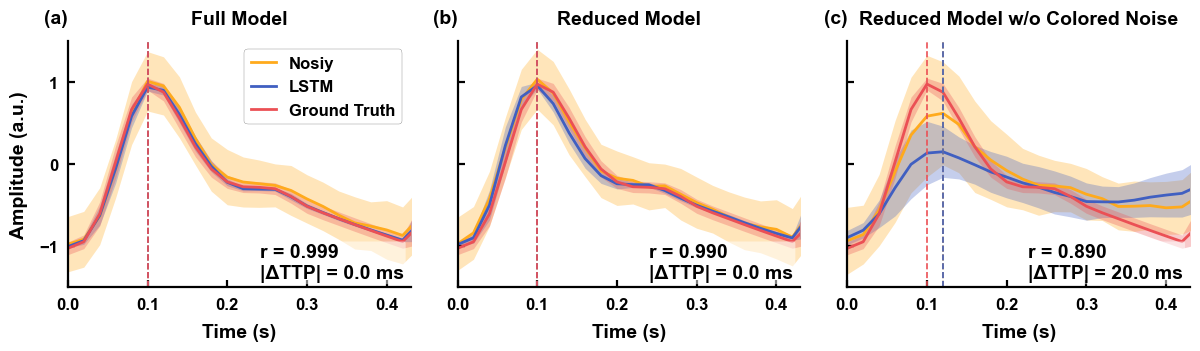

In [17]:
# 1×3 averaged‐pulse comparison for three models
fig, axes = plt.subplots(1, 3, figsize=(6.2, 2.0), sharey=True)

axes = np.atleast_1d(axes)

model_labels = ["Full Model", "Reduced Model", "Reduced Model w/o Colored Noise"]
results_list = [results1, results2, results3]
results_noisy_list = [results1_noisy, results2_noisy, results3_noisy]

y_min, y_max = -1.5, 1.5
x_max = 0.8  # adjust if your pulses are longer/shorter

i = 0
for ax, res, res_noisy, title in zip(axes, results_list, results_noisy_list, model_labels):
    # Unpack from result dict
    x_noisy     = res_noisy["x_pulse"]
    mean_noisy  = res_noisy["filtered_mean_pulse"]
    std_noisy   = res_noisy["filtered_std_pulse"]

    x_proc = res["x_pulse"]
    mean_proc   = res["filtered_mean_pulse"]
    std_proc    = res["filtered_std_pulse"]

    # Plot noisy mean + shaded std
    ax.plot(x_noisy, mean_noisy, color=color5[2], label='Nosiy', linewidth=1)
    ax.fill_between(x_noisy, mean_noisy - std_noisy, mean_noisy + std_noisy,
                    color=color5[2], alpha=0.30, linewidth=0)

    # Plot processed mean + shaded std
    ax.plot(x_proc, mean_proc, color=color5[1], label='LSTM', linewidth=1)
    ax.fill_between(x_proc, mean_proc - std_proc, mean_proc + std_proc,
                    color=color5[1], alpha=0.30, linewidth=0)

    # Plot ground truth mean + shaded std
    ax.plot(x_gt, mean_gt, color=color5[0], label='Ground Truth', linewidth=1)
    ax.fill_between(x_gt, mean_gt - std_gt, mean_gt + std_gt,
                    color=color5[0], alpha=0.30, linewidth=0)

    # TTP vertical lines (use each trace's own time axis)
    ttp_raw = x_noisy[np.argmax(mean_noisy)]
    ttp_proc = x_proc[np.argmax(mean_proc)]
    ax.vlines(ttp_raw,  y_min, y_max, color=color5[2], linestyle='--', linewidth=0.6)
    ax.vlines(ttp_proc, y_min, y_max, color=color5[1], linestyle='--', linewidth=0.6)
    ax.vlines(ttp_gt, y_min, y_max, color=color5[0], linestyle='--', linewidth=0.6)

    # Annotation (bottom-right)
    ax.text(
        0.98, 0.02,
        f"r = {r_all[i]:.3f}\n|ΔTTP| = {delta_tpp_all[i]*1000:.1f} ms",
        transform=ax.transAxes, ha="right", va="bottom",
        fontsize=7, fontweight='bold', multialignment="left",
        bbox=dict(boxstyle="round,pad=0.1", facecolor="white", alpha=0.5, linewidth=0)
    )

    # Cosmetics
    ax.set_title(title, fontsize=7)
    ax.set_xlim(0, x_max)
    ax.set_ylim(y_min, y_max)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=6)

    ax.text(0, 1.13, f'({chr(97 + i)})', transform=ax.transAxes, fontsize=7, fontweight='bold', va='top', ha='right')
    i += 1

# Shared labels and a single legend
axes[0].set_ylabel('Amplitude (a.u.)', fontsize=7)
for ax in axes:
    ax.set_xlabel('Time (s)', fontsize=7)
    ax.set_xlim(0, 0.43)
    ax.set_xticks([0, 0.1, 0.2, 0.3, 0.4])
    ax.set_ylim(-1.5, 1.5)
    ax.set_yticks([-1, 0, 1])

# One legend (from the first axes) to avoid clutter
handles, labels = axes[0].get_legend_handles_labels()
leg = axes[0].legend(handles, labels, fontsize=6, frameon=True, framealpha=0.7, loc='upper right',
                     handlelength=1.5)
leg.get_frame().set_linewidth(0.1)

plt.tight_layout(w_pad=0.8)
# plt.savefig('fig21_average_pulse_lstm_models.png', dpi=600, bbox_inches='tight')
plt.show()


## 6. Quantitative Analyses: Peak/Valley Identification, IBI and HR accuray

### Peak and valley analyses
Evaluate peaks and valleys against ground truth for the three methods we have: LSTM, DWT, and TDDR. A ±60 ms tolerance is set by default (equivalent to 3 data points for 50 Hz sampling frequency). We will report TP/FP/FN, precision/recall/F1, and timing error stats (bias, SD, MAE, RMSE, 95th percentile of |error|)

**Identify peaks and valleys**:

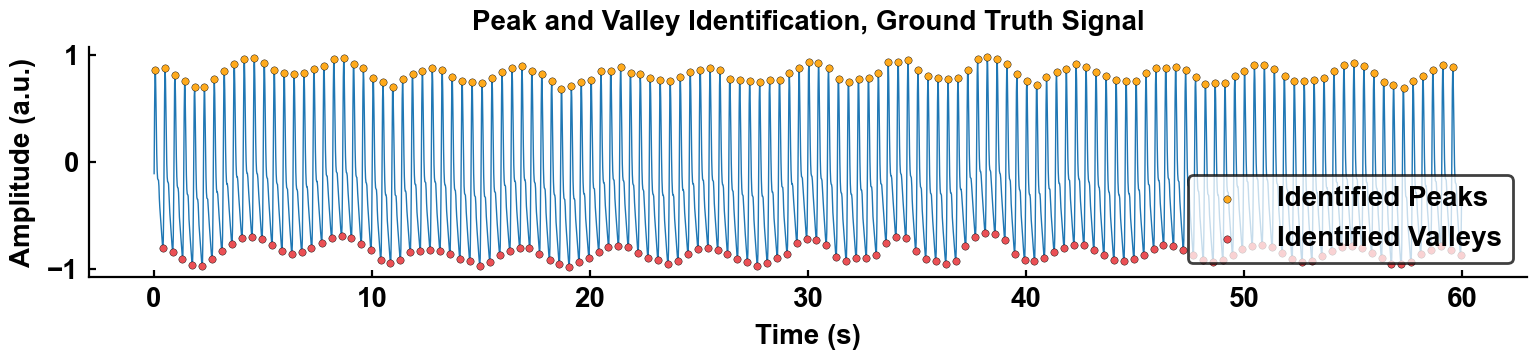

In [18]:
# Extract IBI and instantaneous HR from the ground truth signal
peak_times_gt, peak_heights_gt, ibi_gt, hr_gt = extract_ibi_hr(data_clean.squeeze(), fs_target, height=0.1, prominence=0.1, distance=0.25*fs_target)
valley_times_gt, valley_heights_gt, _, _ = extract_ibi_hr(-data_clean.squeeze(), fs_target, height=0.1, prominence=0.1, distance=0.25*fs_target)

fig, ax = plt.subplots(figsize=(8, 2))
ax.plot(t_nirs,data_clean.squeeze(),linewidth=0.5)
ax.scatter(peak_times_gt,peak_heights_gt, marker='o', edgecolors='black', linewidth=0.15, s=7, color=color5[2], zorder=2, label='Identified Peaks')
ax.scatter(valley_times_gt,-valley_heights_gt, marker='o', edgecolors='black', linewidth=0.15, s=7, color=color5[0], zorder=2, label='Identified Valleys')
ax.legend(frameon=True, framealpha=0.75, loc=4)
ax.set_title("Peak and Valley Identification, Ground Truth Signal")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Amplitude (a.u.)")

plt.tight_layout()
plt.show()


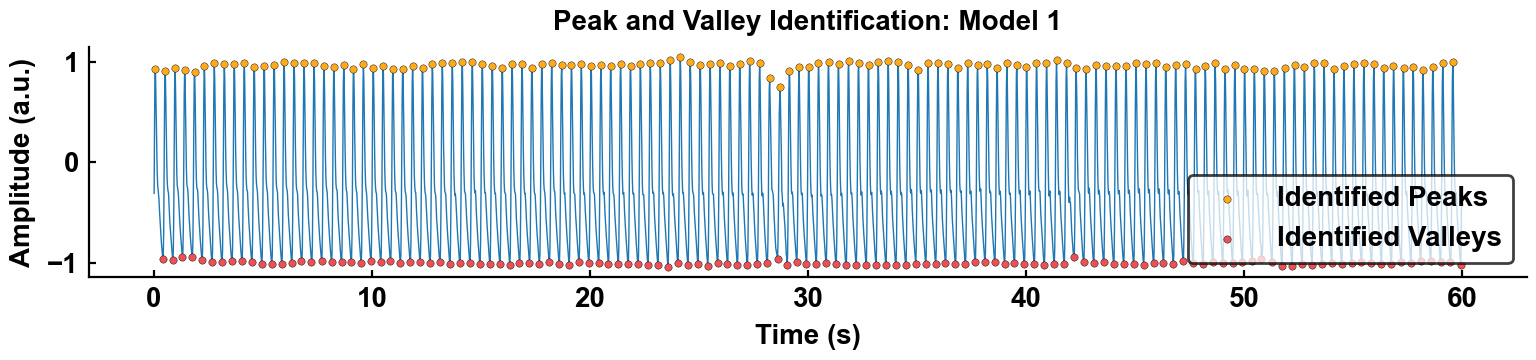

Ground truth HR is 132 bpm.


In [19]:
# IBI and HR from the LSTM Model 1, full model
peak_times_lstm1, peak_heights_lstm1, ibi_lstm1, hr_lstm1 = extract_ibi_hr(processed_time_trace1.squeeze(), fs_target, height=0.1, prominence=0.1, distance=0.25*fs_target)
valley_times_lstm1, valley_heights_lstm1, _, _ = extract_ibi_hr(-processed_time_trace1.squeeze(), fs_target, height=0.1, prominence=0.1, distance=0.25*fs_target)

fig, ax = plt.subplots(figsize=(8, 2))
ax.plot(t_nirs,processed_time_trace1.squeeze(),linewidth=0.5)
ax.scatter(peak_times_lstm1,peak_heights_lstm1, marker='o', edgecolors='black', linewidth=0.15, s=7, color=color5[2], zorder=2, label='Identified Peaks')
ax.scatter(valley_times_lstm1,-valley_heights_lstm1, marker='o', edgecolors='black', linewidth=0.15, s=7, color=color5[0], zorder=2, label='Identified Valleys')
ax.legend(frameon=True, framealpha=0.75, loc=4)
ax.set_title("Peak and Valley Identification: Model 1")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Amplitude (a.u.)")

plt.tight_layout()
plt.show()

hr_gt_bpm = len(peak_times_gt) # This is a 60 seconds signal
print("Ground truth HR is " + str(hr_gt_bpm) + " bpm.")


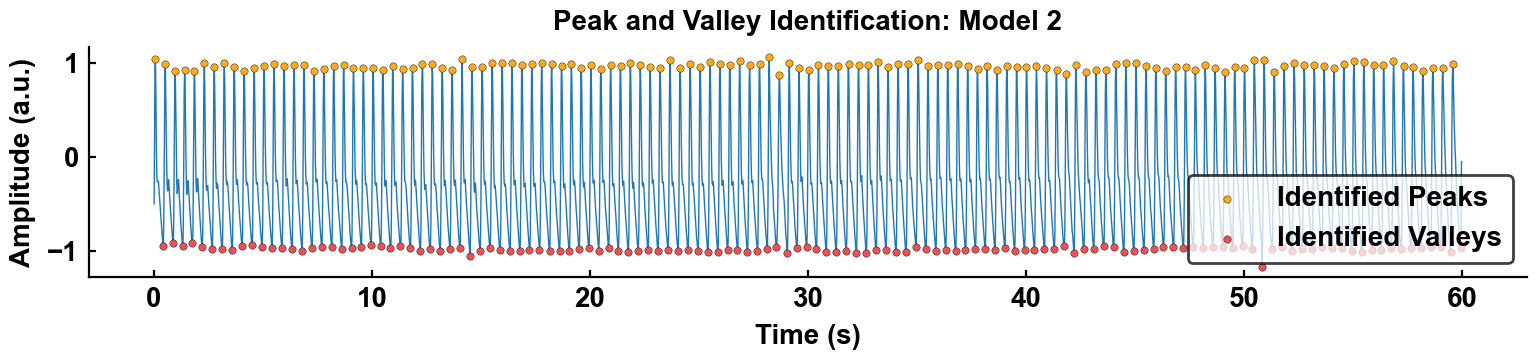

In [20]:
# IBI and HR from the LSTM Model 2, reduced model
peak_times_lstm2, peak_heights_lstm2, ibi_lstm2, hr_lstm2 = extract_ibi_hr(processed_time_trace2.squeeze(), fs_target, prominence=0.5, distance=0.25*fs_target)
valley_times_lstm2, valley_heights_lstm2, _, _ = extract_ibi_hr(-processed_time_trace2.squeeze(), fs_target, prominence=0.5, distance=0.25*fs_target)

fig, ax = plt.subplots(figsize=(8, 2))
ax.plot(t_nirs,processed_time_trace2.squeeze(),linewidth=0.5)
ax.scatter(peak_times_lstm2,peak_heights_lstm2, marker='o', edgecolors='black', linewidth=0.15, s=7, color=color5[2], zorder=2, label='Identified Peaks')
ax.scatter(valley_times_lstm2,-valley_heights_lstm2, marker='o', edgecolors='black', linewidth=0.15, s=7, color=color5[0], zorder=2, label='Identified Valleys')
ax.legend(frameon=True, framealpha=0.75, loc=4)
ax.set_title("Peak and Valley Identification: Model 2")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Amplitude (a.u.)")

plt.tight_layout()
plt.show()


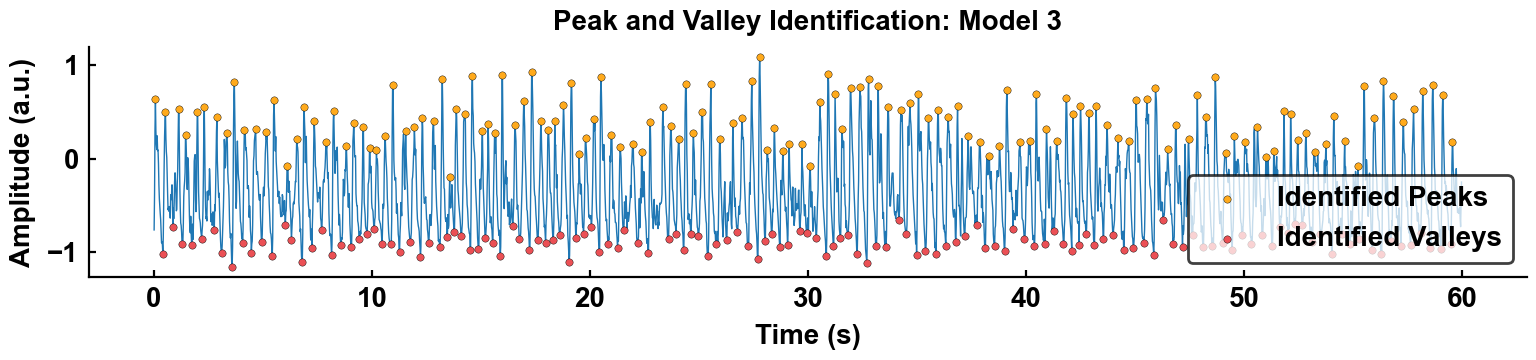

In [21]:
# IBI and HR from the LSTM Model 3, reduced model without colored noise
peak_times_lstm3, peak_heights_lstm3, ibi_lstm3, hr_lstm3 = extract_ibi_hr(processed_time_trace3.squeeze(), fs_target, prominence=0.5, distance=0.25*fs_target)
valley_times_lstm3, valley_heights_lstm3, _, _ = extract_ibi_hr(-processed_time_trace3.squeeze(), fs_target, prominence=0.5, distance=0.25*fs_target)

fig, ax = plt.subplots(figsize=(8, 2))
ax.plot(t_nirs,processed_time_trace3.squeeze(),linewidth=0.5)
ax.scatter(peak_times_lstm3,peak_heights_lstm3, marker='o', edgecolors='black', linewidth=0.15, s=7, color=color5[2], zorder=2, label='Identified Peaks')
ax.scatter(valley_times_lstm3,-valley_heights_lstm3, marker='o', edgecolors='black', linewidth=0.15, s=7, color=color5[0], zorder=2, label='Identified Valleys')
ax.legend(frameon=True, framealpha=0.75, loc=4)
ax.set_title("Peak and Valley Identification: Model 3")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Amplitude (a.u.)")

plt.tight_layout()
plt.show()


**Functions for matching detected peaks/valleys to the ground truth ones:**

In [22]:
def match_events(gt_times, est_times, tol_s):
    """
    One-to-one greedy nearest-neighbor matching within ±tol_s.
    Returns: (idx_gt, idx_est, dt) where dt = est_time - gt_time for matched pairs.
    """
    gt = np.asarray(gt_times, dtype=float).ravel()
    est = np.asarray(est_times, dtype=float).ravel()
    if gt.size == 0 or est.size == 0:
        return np.array([], int), np.array([], int), np.array([], float)

    used_gt = np.zeros(gt.size, dtype=bool)
    idx_gt, idx_est, dt = [], [], []
    for j, te in enumerate(est):
        # nearest GT index to this estimate
        i = int(np.argmin(np.abs(gt - te)))
        if not used_gt[i] and abs(gt[i] - te) <= tol_s:
            used_gt[i] = True
            idx_gt.append(i)
            idx_est.append(j)
            dt.append(te - gt[i])

    return np.asarray(idx_gt, int), np.asarray(idx_est, int), np.asarray(dt, float)

def stats_timing(errors_s):
    """
    Timing error stats from array of dt (seconds).
    Returns dict with bias (s), sd (s), mae (s), rmse (s), p95_abs (s).
    """
    e = np.asarray(errors_s, float)
    if e.size == 0:
        return dict(bias=np.nan, sd=np.nan, mae=np.nan, rmse=np.nan, p95_abs=np.nan, n=0)
    return dict(
        bias = float(np.mean(e)),
        sd   = float(np.std(e, ddof=1)) if e.size > 1 else 0.0,
        mae  = float(np.mean(np.abs(e))),
        rmse = float(np.sqrt(np.mean(e**2))),
        p95_abs = float(np.percentile(np.abs(e), 95)),
        n = int(e.size)
    )

def detection_metrics(n_gt, n_est, n_matched):
    tp = int(n_matched)
    fn = int(n_gt - n_matched)
    fp = int(n_est - n_matched)
    precision = tp / (tp + fp) if (tp + fp) > 0 else np.nan
    recall    = tp / (tp + fn) if (tp + fn) > 0 else np.nan
    f1 = (2*precision*recall / (precision + recall)) if np.isfinite(precision) and np.isfinite(recall) and (precision+recall) > 0 else np.nan
    return dict(TP=tp, FP=fp, FN=fn, precision=precision, recall=recall, f1=f1)

def evaluate_events_one(gt_times, est_times, label, tol_s=0.06):
    """
    Evaluate a single method vs ground truth for either peaks or valleys.
    Prints a concise summary and returns a result dict.
    """
    idx_gt, idx_est, dt = match_events(gt_times, est_times, tol_s)
    det = detection_metrics(len(gt_times), len(est_times), len(dt))
    st  = stats_timing(dt)
    print(f"\n[{label}]  tol = ±{1000*tol_s:.0f} ms")
    print(f"  Counts: GT={len(gt_times)}, EST={len(est_times)}, TP={det['TP']}, FP={det['FP']}, FN={det['FN']}")
    print(f"  Detect: Precision={det['precision']:.3f}  Recall={det['recall']:.3f}  F1={det['f1']:.3f}")
    print(f"  Timing (matched {st['n']}): "
          f"bias={st['bias']*1000:.1f} ms, sd={st['sd']*1000:.1f} ms, "
          f"MAE={st['mae']*1000:.1f} ms, RMSE={st['rmse']*1000:.1f} ms, "
          f"P95|err|={st['p95_abs']*1000:.1f} ms")
    return dict(detection=det, timing_stats_s=st, matched_pairs=(idx_gt, idx_est), dt_s=dt)


**Results: detections accuracy**

In [23]:
def evaluate_peaks_and_valleys(tol_s):
    results = {}

    # --- Peaks ---
    results['peaks_lstm1'] = evaluate_events_one(peak_times_gt,   peak_times_lstm1,  "Peaks • LSTM Model 1", tol_s)
    results['peaks_lstm2']   = evaluate_events_one(peak_times_gt,   peak_times_lstm2,    "Peaks • LSTM Model 2", tol_s)
    results['peaks_lstm3'] = evaluate_events_one(peak_times_gt,   peak_times_lstm3,  "Peaks • LSTM Model 3", tol_s)

    # --- Valleys ---
    results['valleys_lstm1'] = evaluate_events_one(valley_times_gt, valley_times_lstm1, "Valleys • LSTM Model 1", tol_s)
    results['valleys_lstm2']   = evaluate_events_one(valley_times_gt, valley_times_lstm2,   "Valleys • LSTM Model 2", tol_s)
    results['valleys_lstm3'] = evaluate_events_one(valley_times_gt, valley_times_lstm3, "Valleys • LSTM Model 3", tol_s)

    return results

In [24]:
tol_ms = 60.0 # change this to try difference tolerance
tol_s = 0.001*tol_ms

results_peak_valley = evaluate_peaks_and_valleys(tol_s)


[Peaks • LSTM Model 1]  tol = ±60 ms
  Counts: GT=132, EST=132, TP=132, FP=0, FN=0
  Detect: Precision=1.000  Recall=1.000  F1=1.000
  Timing (matched 132): bias=-0.0 ms, sd=8.9 ms, MAE=3.9 ms, RMSE=8.9 ms, P95|err|=20.0 ms

[Peaks • LSTM Model 2]  tol = ±60 ms
  Counts: GT=132, EST=132, TP=132, FP=0, FN=0
  Detect: Precision=1.000  Recall=1.000  F1=1.000
  Timing (matched 132): bias=-5.9 ms, sd=10.1 ms, MAE=6.8 ms, RMSE=11.7 ms, P95|err|=20.0 ms

[Peaks • LSTM Model 3]  tol = ±60 ms
  Counts: GT=132, EST=142, TP=72, FP=70, FN=60
  Detect: Precision=0.507  Recall=0.545  F1=0.526
  Timing (matched 72): bias=4.4 ms, sd=19.3 ms, MAE=13.3 ms, RMSE=19.7 ms, P95|err|=40.0 ms

[Valleys • LSTM Model 1]  tol = ±60 ms
  Counts: GT=132, EST=132, TP=132, FP=0, FN=0
  Detect: Precision=1.000  Recall=1.000  F1=1.000
  Timing (matched 132): bias=-2.7 ms, sd=9.8 ms, MAE=4.8 ms, RMSE=10.2 ms, P95|err|=20.0 ms

[Valleys • LSTM Model 2]  tol = ±60 ms
  Counts: GT=132, EST=132, TP=132, FP=0, FN=0
  Detec

### IBI/HR comparison

**Functions for matching IBI/HR, smoothing, and calculating MAE and RMSE:**

In [25]:
from scipy.interpolate import interp1d

def _pearson_r(a, b):
    return np.corrcoef(a, b)[0, 1]

def _restrict_to_common_range(t1, y1, t2, y2, eps=1e-12):
    """
    Trim both (t, y) series to their TRUE overlap [tmin, tmax] so we never extrapolate.
    """
    if len(t1) == 0 or len(t2) == 0:
        return np.array([]), np.array([]), np.array([]), np.array([])
    tmin = max(float(np.min(t1)), float(np.min(t2)))
    tmax = min(float(np.max(t1)), float(np.max(t2)))
    if not (tmax > tmin):
        return np.array([]), np.array([]), np.array([]), np.array([])
    m1 = (t1 >= tmin - eps) & (t1 <= tmax + eps)
    m2 = (t2 >= tmin - eps) & (t2 <= tmax + eps)
    return t1[m1], y1[m1], t2[m2], y2[m2]

def compare_ibi_on_shorter_axis(peak_times_gt, ibi_gt, peak_times_est, ibi_est, label="Method"):
    """
    Compare IBI series by interpolating onto the SHORTER axis within the common overlap.
    IBI time axis = start-of-interval times: t = peak_times[:-1]
    No extrapolation (hard-masked to interpolation domain).

    Returns
    -------
    dict with:
      - mae_ms, rmse_ms, r, N
      - t_axis: np.ndarray, the time axis actually used for comparison (seconds)
      - ibi_gt_aligned: np.ndarray, GT IBI values aligned to t_axis (seconds)
      - ibi_est_aligned: np.ndarray, EST IBI values aligned to t_axis (seconds)
    """
    peak_times_gt  = np.asarray(peak_times_gt,  float).ravel()
    peak_times_est = np.asarray(peak_times_est, float).ravel()
    ibi_gt  = np.asarray(ibi_gt,  float).ravel()
    ibi_est = np.asarray(ibi_est, float).ravel()

    # IBI time axes: start-of-interval times
    t_gt  = peak_times_gt[:-1]
    t_est = peak_times_est[:-1]

    # Trim to true overlap so we never extrapolate
    t_gt_c, ibi_gt_c, t_est_c, ibi_est_c = _restrict_to_common_range(t_gt, ibi_gt, t_est, ibi_est)
    if t_gt_c.size < 2 or t_est_c.size < 2:
        print(f"[{label}] Not enough overlapping points for interpolation.")
        return {"mae_ms": np.nan, "rmse_ms": np.nan, "r": np.nan, "N": 0,
                "t_axis": np.array([]), "ibi_gt_aligned": np.array([]), "ibi_est_aligned": np.array([])}

    # Choose target = shorter clipped axis
    if t_gt_c.size <= t_est_c.size:
        t_target_full = t_gt_c
        y_ref = ibi_gt_c
        dom_lo, dom_hi = t_est_c[0], t_est_c[-1]
        mask = (t_target_full >= dom_lo) & (t_target_full <= dom_hi)
        t_axis = t_target_full[mask]
        y_ref  = y_ref[mask]
        if t_axis.size < 2:
            print(f"[{label}] Overlap after domain mask too small.")
            return {"mae_ms": np.nan, "rmse_ms": np.nan, "r": np.nan, "N": 0,
                    "t_axis": np.array([]), "ibi_gt_aligned": np.array([]), "ibi_est_aligned": np.array([])}
        f_est = interp1d(t_est_c, ibi_est_c, kind="linear", bounds_error=False, fill_value=np.nan, assume_sorted=False)
        y_other = f_est(t_axis)
        ibi_gt_aligned, ibi_est_aligned = y_ref, y_other
    else:
        t_target_full = t_est_c
        y_ref = ibi_est_c
        dom_lo, dom_hi = t_gt_c[0], t_gt_c[-1]
        mask = (t_target_full >= dom_lo) & (t_target_full <= dom_hi)
        t_axis = t_target_full[mask]
        y_ref  = y_ref[mask]
        if t_axis.size < 2:
            print(f"[{label}] Overlap after domain mask too small.")
            return {"mae_ms": np.nan, "rmse_ms": np.nan, "r": np.nan, "N": 0,
                    "t_axis": np.array([]), "ibi_gt_aligned": np.array([]), "ibi_est_aligned": np.array([])}
        f_gt = interp1d(t_gt_c, ibi_gt_c, kind="linear", bounds_error=False, fill_value=np.nan, assume_sorted=False)
        y_other = f_gt(t_axis)
        ibi_gt_aligned, ibi_est_aligned = y_other, y_ref

    # Remove any residual NaNs (shouldn’t occur after masking, but keep safe)
    m = np.isfinite(ibi_gt_aligned) & np.isfinite(ibi_est_aligned)
    if np.count_nonzero(m) < 2:
        print(f"[{label}] Too few valid samples after alignment.")
        return {"mae_ms": np.nan, "rmse_ms": np.nan, "r": np.nan, "N": 0,
                "t_axis": np.array([]), "ibi_gt_aligned": np.array([]), "ibi_est_aligned": np.array([])}
    t_axis        = t_axis[m]
    ibi_gt_aligned  = ibi_gt_aligned[m]
    ibi_est_aligned = ibi_est_aligned[m]

    # Metrics
    err     = ibi_est_aligned - ibi_gt_aligned  # seconds
    mae_ms  = float(np.mean(np.abs(err)) * 1000.0)
    rmse_ms = float(np.sqrt(np.mean(err**2)) * 1000.0)
    r_val   = _pearson_r(ibi_gt_aligned, ibi_est_aligned)
    N       = int(t_axis.size)

    # print(f"[{label}] IBI on shorter overlap axis: N={N}, "
    #       f"MAE={mae_ms:.1f} ms, RMSE={rmse_ms:.1f} ms, r={r_val:.3f}")

    return {
        "mae_ms": mae_ms, "rmse_ms": rmse_ms, "r": r_val, "N": N,
        "t_axis": t_axis,                         # seconds
        "ibi_gt_aligned": ibi_gt_aligned,         # seconds
        "ibi_est_aligned": ibi_est_aligned        # seconds
    }

def _smooth_beats(x, k):
    if k is None or k <= 1:
        return x
    k = int(k)
    if k % 2 == 0:
        k += 1  # force odd for centering
    w = np.ones(k, dtype=float) / k
    # 'same' keeps length; pad with edge values to avoid shrinkage
    pad = k // 2
    xp = np.pad(x, (pad, pad), mode='edge')
    return np.convolve(xp, w, mode='valid')

def compare_ibi_on_shorter_axis_with_hr_smoothing(
    peak_times_gt, ibi_gt, peak_times_est, ibi_est, label="Method", hr_smooth_beats=1
):
    res = compare_ibi_on_shorter_axis(peak_times_gt, ibi_gt, peak_times_est, ibi_est, label=label)

    # If alignment failed or too few points, just return unchanged keys plus NaNs for smoothed HR
    if res["N"] < 2 or res["ibi_gt_aligned"].size < 2:
        res.update({
            "hr_mae_bpm_smooth": np.nan,
            "hr_rmse_bpm_smooth": np.nan,
            "hr_r_smooth": np.nan,
        })
        return res

    # Build HR from aligned IBIs (seconds → bpm)
    ibi_gt_aln  = res["ibi_gt_aligned"]
    ibi_est_aln = res["ibi_est_aligned"]
    mpos = (ibi_gt_aln > 0) & (ibi_est_aln > 0) & np.isfinite(ibi_gt_aln) & np.isfinite(ibi_est_aln)
    if np.count_nonzero(mpos) < 2:
        res.update({
            "hr_mae_bpm_smooth": np.nan,
            "hr_rmse_bpm_smooth": np.nan,
            "hr_r_smooth": np.nan,
        })
        return res

    hr_gt  = 60.0 / ibi_gt_aln[mpos]
    hr_est = 60.0 / ibi_est_aln[mpos]

    # Optional beat-smoothing (identical on both)
    hr_gt_s  = _smooth_beats(hr_gt,  hr_smooth_beats)
    hr_est_s = _smooth_beats(hr_est, hr_smooth_beats)

    # Align lengths after smoothing (edges can differ by at most a beat)
    L = min(hr_gt_s.size, hr_est_s.size)
    hr_gt_s, hr_est_s = hr_gt_s[:L], hr_est_s[:L]

    # Metrics on smoothed HR
    diff = hr_est_s - hr_gt_s
    hr_mae_bpm_s  = float(np.mean(np.abs(diff)))
    hr_rmse_bpm_s = float(np.sqrt(np.mean(diff**2)))
    hr_r_s        = float(np.corrcoef(hr_gt_s, hr_est_s)[0, 1]) if L > 1 else np.nan

    res.update({
        "hr_mae_bpm_smooth": hr_mae_bpm_s,
        "hr_rmse_bpm_smooth": hr_rmse_bpm_s,
        "hr_r_smooth": hr_r_s,
        "hr_gt_smoothed": hr_gt_s, "hr_est_smoothed": hr_est_s, # for plotting
    })

    # Optional print for visibility (comment out if noisy)
    print(f"[{label}] HR (smoothed over {hr_smooth_beats} beats): "
          f"MAE={hr_mae_bpm_s:.2f} bpm, RMSE={hr_rmse_bpm_s:.2f} bpm, r={hr_r_s:.3f}")

    return res


**Results:**

**Note:** While MAE and RMSE between LSTM-derived and ground-truth HR are low, the Pearson correlation (r) appears modest. This is expected because the mean HR is nearly constant across the 60-s window, so even small beat-to-beat differences (1–2 samples in IBI) disproportionately reduce r. In other words, the traces are highly consistent in absolute terms, but correlation is less informative under near-constant HR conditions.


In [26]:
hr_smooth_beats = 5 # smooth over N beats

result_hr_lstm1 = compare_ibi_on_shorter_axis_with_hr_smoothing(peak_times_gt, ibi_gt, peak_times_lstm1, ibi_lstm1, label="LSTM Model 1", hr_smooth_beats=hr_smooth_beats)
result_hr_lstm2 = compare_ibi_on_shorter_axis_with_hr_smoothing(peak_times_gt, ibi_gt, peak_times_lstm2, ibi_lstm2, label="LSTM Model 2", hr_smooth_beats=hr_smooth_beats)
result_hr_lstm3 = compare_ibi_on_shorter_axis_with_hr_smoothing(peak_times_gt, ibi_gt, peak_times_lstm3, ibi_lstm3, label="LSTM Model 3", hr_smooth_beats=hr_smooth_beats)


[LSTM Model 1] HR (smoothed over 5 beats): MAE=0.46 bpm, RMSE=0.79 bpm, r=0.669
[LSTM Model 2] HR (smoothed over 5 beats): MAE=0.57 bpm, RMSE=0.86 bpm, r=0.628
[LSTM Model 3] HR (smoothed over 5 beats): MAE=11.83 bpm, RMSE=16.52 bpm, r=-0.075


**Paper figure: plot smoothed HR time traces**

**Note:** In the paper, smoothing was implemented with a simple moving average (`np.convolve` with `mode='valid'`), which shortens the signal at the edges. In this repository, we use an improved function (`_smooth_beats`) with edge padding to preserve signal length. This caused minor visual differences from the paper figures, but the results are consistent.


In [27]:
hr_gt_smoothed = result_hr_lstm1['hr_gt_smoothed']
hr_lstm1_smoothed = result_hr_lstm1['hr_est_smoothed']
hr_lstm2_smoothed = result_hr_lstm2['hr_est_smoothed']
hr_lstm3_smoothed = result_hr_lstm3['hr_est_smoothed']


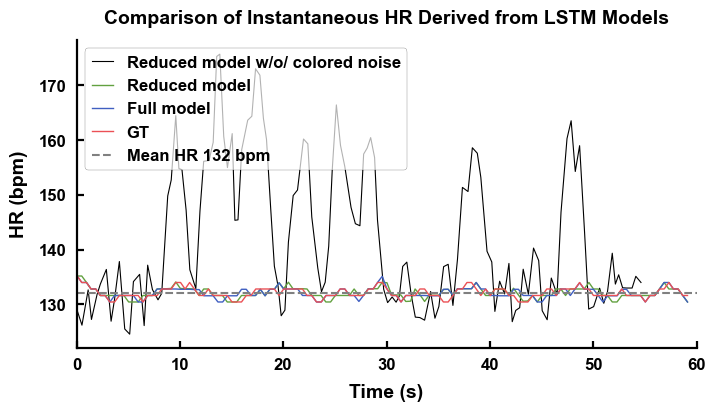

In [28]:
# Plot the HR time traces
fig, ax = plt.subplots(figsize=(4, 2))
ax.plot(peak_times_lstm3[:len(hr_lstm3_smoothed)], hr_lstm3_smoothed,label='Reduced model w/o/ colored noise',linewidth=0.4,color='k')
ax.plot(peak_times_lstm2[:len(hr_lstm2_smoothed)], hr_lstm2_smoothed,label='Reduced model',linewidth=0.5,color=color5[3])
ax.plot(peak_times_lstm1[:len(hr_lstm1_smoothed)], hr_lstm1_smoothed,label='Full model',linewidth=0.5,color=color5[1])
ax.plot(peak_times_gt[:len(hr_gt_smoothed)], hr_gt_smoothed,label='GT',linewidth=0.5,color=color5[0])

ax.hlines(y = hr_gt_bpm, xmin=0, xmax=60, color = [0.5,0.5,0.5], linestyle='--', linewidth=0.75, label=f'Mean HR {hr_gt_bpm} bpm')

ax.set_title('Comparison of Instantaneous HR Derived from LSTM Models', fontsize=7)
ax.set_xlabel('Time (s)', fontsize=7)
ax.set_ylabel('HR (bpm)', fontsize=7)


lgd = ax.legend(fontsize=6,frameon=True, framealpha=0.7, ncol=1, loc=2, handlelength=1.3)
lgd.get_frame().set_linewidth(0.1)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_xlim(0, 60)

# Save the figure if needed
# plt.savefig('HR_compare_lstm_models.png', dpi=600, bbox_inches='tight')

plt.show()